<h1><center>Telco Customer Churn - Churn Prediction & Segmentation</center></h1>

# 1. Introduction # 



**1.1 Goal**

The aim of this notebook is to estimate the churn probability of customers (classification using neural network as well as other machine learning models) and identify the customers which are worth the effort to hold them (segmentation).


**1.2 Relevance**

According to experts, the cost of acquiring new customers is up to five times higher than keeping existing customers. Customer loyalty is therefore a central goal of a sustainable business strategy. An important element of this strategy is the prevention of customer churn. In the digital age, this is more true than ever, as offers can be compared very easily.

In the telecommunication sector customer churn is one of the biggest problems. Vodafone, for example, had a churn rate of 12% in Germany, 24% in Italy, 26% in the UK and even 28% in Spain in the fourth quarter of the 2020/21 financial year (source: https://www.statista.com/statistics/972046/vodafone-churn-rate-european-countries/). It is therefore important for telecommunication companies to analyze relevant customer data  and, based on this, develop a robust churn prediction model in order to retain customers and develop strategies to reduce the churn rate.

However, not all customers with a (very) high churn rate are worth the effort to keep them equally. In order to answer the question of which are the best customers of my company, a customer segmentation is necessary.


**1.3 Research Questions**

* Which customers have a very high / high / middle / low / very low risk to churn (classification)? 
* Which customers with (very) high churn rate are worth to be retained (segmentation)?

# 2. Data Preparation

**2.1 Import Libraries**

To analyse the data, we first need to import the required libraries:

In [ ]:
# import libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import hstack
from numpy import vstack
from numpy import asarray
import seaborn as sns
from catboost import CatBoostClassifier
from collections import OrderedDict
cmaps = OrderedDict()
import os
import warnings

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

**2.2 Define Colors**

Customized colors for plotting are defined:

In [ ]:
# definition of colors
custom_colors=['#c14953','#d96548','#f2a553','#f3c969','#98e2c6', '#86c1b2', '#74a09e']
custom_colors1=['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
custom_colors_yes_no_gray=['#595959', '#D9D9D9']
customPalette = sns.set_palette(sns.color_palette(custom_colors))

**2.3 Load Data**

I created one dataset out of the following single datasets to get additional features (like satisfaction score, total revenues and cltv) for churn prediction and increase the accuracy of the models:

* https://www.kaggle.com/blastchar/telco-customer-churn ("../input/d/blastchar/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv../input/d/blastchar/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
* https://www.kaggle.com/ylchang/telco-customer-churn-1113 ("../input/telco-customer-churn-1113../input/telco-customer-churn-1113")

In part 1 of this notebook (https://www.kaggle.com/sibelius5/customer-churn-part-1-edahttps://www.kaggle.com/sibelius5/customer-churn-part-1-eda) I cleaned the merged dataset ("Telco_customer_churn_cleaned.csv""Telco_customer_churn_cleaned.csv").

So, we load the merged and already cleaned dataset:

In [ ]:
# load data
df = pd.read_csv("../input/telco-customer-churn/Telco_customer_churn_cleaned.csv")

We have to run the following step again:

In [ ]:
# convert data types and impute missing values with zero
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0).astype("float32")
df["Satisfaction Score"] = df["Satisfaction Score"].astype("object")
df["SeniorCitizen"] = df["SeniorCitizen"].replace(0, "0").replace(1, "1") 

We use the head() function to show the first 5 rows:

In [ ]:
df.head()

...and the info() function to show data types:

In [ ]:
df.info()

**2.4 Define Variables**

To simplify the code later on, columns/variables are written like this:

In [ ]:
# variable defintions
customer_id = df["customerID"]
gender = df["gender"]
senior_citizen = df["SeniorCitizen"]
partner = df["Partner"]
dependents = df["Dependents"]
tenure = df["tenure"]
phone_service = df["PhoneService"]
multiple_lines = df["MultipleLines"]
internet_service = df["InternetService"]
online_security = df["OnlineSecurity"]
online_backup = df["OnlineBackup"]
device_protection = df["DeviceProtection"]
tech_support = df["TechSupport"]
streaming_tv = df["StreamingTV"]
streaming_movies = df["StreamingMovies"]
contract = df["Contract"]
paperless_billing = df["PaperlessBilling"]
payment_method = df["PaymentMethod"]
monthly_charges = df["MonthlyCharges"]
total_charges = df["TotalCharges"]
churn = df["Churn"] #churn yes/no
churn_rate = df["churn_rate"] #churn 1/0
cltv = df["CLTV"]
churn_reason = df["Churn Reason"]
country = df["Country"]
state = df["State"]
city = df["City"]
zip_code = df["Zip Code"]
lat_long = df["Lat Long"]
latitude = df["Latitude"]
longitude = df["Longitude"]
age = df["Age"]
married = df["Married"]
referred_a_friend = df["Referred a Friend"]
number_of_referrals = df["Number of Referrals"]
offer = df["Offer"]
avg_monthly_long_distance_charges = df["Avg Monthly Long Distance Charges"]
avg_monthly_gb_download = df["Avg Monthly GB Download"]
streaming_music = df["Streaming Music"]
premium_tech_support = df["Premium Tech Support"]
unlimited_data = df["Unlimited Data"]
total_refunds = df["Total Refunds"]
total_extra_data_charges = df["Total Extra Data Charges"]
total_long_distance_charges = df["Total Long Distance Charges"]
total_revenue = df["Total Revenue"]
satisfaction_score = df ["Satisfaction Score"]
customer_status = df["Customer Status"]
churn_category = df["Churn Category"]

**2.5 Split Features**

Features are split into numeric and categorical features. Shape and head for numeric resp. categorical features are shown.

In [ ]:
# numeric features
num_features = df[["tenure", "MonthlyCharges", "TotalCharges", 
                 "CLTV", "Total Revenue"]]

In [ ]:
num_features.head()

In [ ]:
num_features.shape

In [ ]:
cat_features = df[["gender", "SeniorCitizen", "Partner", "Dependents",
                   "PhoneService", "MultipleLines", "InternetService",
                   "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                   "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
                   "PaperlessBilling", "PaymentMethod","Satisfaction Score"]]

In [ ]:
cat_features.head()

In [ ]:
cat_features.shape

**2.6 Feature Engineering**

„Coming up with features is difficult, time-consuming, requires expert knowledge. ‚Applied Machine Learning‘ is basically feature engineering“ (Andrew Ng).



**2.6.1 Create dummy variables for categorical features**

Since ML algorithms require numeric values for the input vector X, the categorical features are first converted into numeric values. The Pandas function pd.get_dummies is used for this. This function converts categorical variables to a series of zeros and ones.

In [ ]:
df_dummy_cat = pd.get_dummies(cat_features)

In [ ]:
df_dummy_cat.head()

In [ ]:
df_dummy_cat.shape

**2.6.2 Normalizing numeric features**

Numerical features also have to be transformed for use in ML algorithms, since the different features usually have different value ranges. Some models, such as decision trees, are not sensitive to the range of values of the features, while other models (especially neural networks) react very strongly to it. The numeric features are therefore normalized.

In part 1 of this notebook we noticed that we have 20 outliers for the feature "total revenue". Even if these outliers are not extreme we have to be careful later on when conducting the churn prediction models. So here we use the StandardScaler, which (in contrast to the MinMaxScaler) can handle outliers well. The StandardScaler does not transform the original data to a specific value range, but rather ensures that the mean value is 0 and the variance is 1 for each feature.

In [ ]:
# define data
x_num = num_features
# define standard scaler
scaler = StandardScaler()
# transform data
x_num_scaled = scaler.fit_transform(x_num)
#print(x_num_scaled)

df_num_features = pd.DataFrame(x_num_scaled)

df_num_features.set_axis(['Tenure', 'MonthlyCharges', 'TotalCharges',
                       "CLTV", "Total Revenue"], 
                      axis='columns')

In [ ]:
df_num_features.head()

In [ ]:
df_num_features.shape

**2.6.3 Concat categorical and numerical features**

After creating dummy variables for categorical features and normalizing numeric features we bring all features together again using pd.concat() function:

In [ ]:
features = pd.concat([df_dummy_cat, df_num_features], axis=1)

In [ ]:
features.head()

In [ ]:
features.shape

**2.6.4 Define X and y variables**

Then we define our X and y variables. Our X variable corresponds to the features, whereas our y variables corresponds to our target variable (= churn rate).

In [ ]:
# Define variables
X = features
y = churn_rate

In [ ]:
X.head()

In [ ]:
X.shape

In [ ]:
y.head()

In [ ]:
y.shape

**2.7 Train Test Split**

Before modeling, the data set is splitted into a training and a test data set by the ratio of 80/20. The training data set contains 5634 rows, the test data set 1409 rows.

In [ ]:
# Split the dataset in train and test-set 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state = 1)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

Now, we can start with our classification. We will use a sequential Keras model (chapter 3) as well as different ML algorithms (chapter 4) and compare them. The best model will be used for our segmentation in chapter 5.

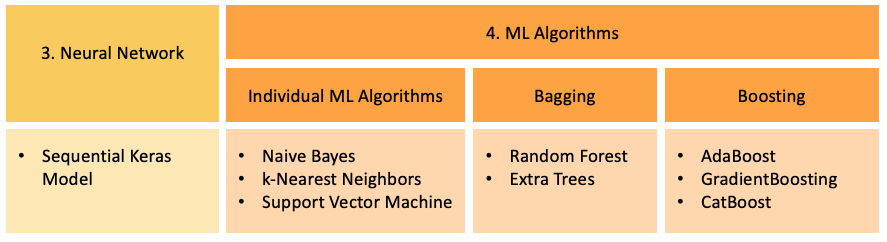

# 3. Neural Network

**3.1 Create Model**

<div class="alert alert-info" role="alert">
At this point I want to pay tribute to an amazing inspiration:
The programming code from Devarsh Raval was adapted for this project part (https://towardsdatascience.com/churn-prediction-using-neural-networks-and-ml-models-c817aadb7057). Thanks for inspiring me and letting me learn from your work!
</div>

* The sequential Keras model consists of 53 input features. 
* The first layer consists of 64 neurons, the second layer of 8 neurons. 
* In the output layer we have an output neuron that gives us the estimated value churn yes / no.

* The dropout method is also used to reduce overfitting. With this method, a certain part of the neurons randomly does not play along in each training cycle, i.e. these are not taken into account for the weight update. This is implemented by the dropout rate, a hyper parameter that represents the probability that a neuron will or will not be involved in the training cycle. This probability is only given to the input neurons and the neurons of the hidden layers, but not to the neurons of the output layer. With the dropout, it takes more training cycles for the network to converge, but the computational effort per training cycle is lower. The dropout rate is set to 0.2 in the first layer and to 0.1 in the second layer.
* The rectified linear unit activation function (ReLU) is used as activation function in the first two layers. Fast learning is possible with this function. The sigmoid function is used in the output layer. So all outputs are between 0 and 1 and can be read as a probability in percent.

In [ ]:
# Create model (Initialisierung) 
nn_model2 = Sequential()
nn_model2.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          input_dim=53, activation='relu'))
##Dropout for not memorize or overfitting the train data
nn_model2.add(layers.Dropout(0.2)) 
nn_model2.add(layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          input_dim=53, activation='relu'))
nn_model2.add(layers.Dropout(0.1)) 
nn_model2.add(layers.Dense(1, activation='sigmoid'))

**3.2 Training**

* After the model has been defined, it is time to execute and train the model. For this purpose, the number of training epochs and the batch size are specified. The number of training epochs indicates how often the training data is presented to the network or how often the model is adapted. 150 epochs are set here. If only a certain amount of training data is presented to the network per epoch, so-called mini-batch gradient descent method is used. This method is also used here. 32 data sets are presented here per epoch (batch size = 32).

* Since we have a binary classification (churn yes / no), binary crossentropy is chosen as the loss function.

* The Adam method is used as optimization method. Adam stands for Adaptive Moment Estimation and takes into account past gradients and their coordinate-wise squared gradients. The advantage of this algorithm is that the learning rate is implicitly reduced or adapted, namely the steeper the fault area, the faster; as a result, one moves more directly towards the optimum in the error space. The learning rate lr is set to 0.001 at the beginning. After every 50th epoch, the learning rate is reduced by half the value.

In [ ]:
# Training

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.0001, 
                                                            decay_steps=(X_train.shape[0]/32)*50,
                                                            decay_rate=1,
                                                            staircase=False)
##Time decay means for every 50 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return
[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                  patience=70, restore_best_weights=True)]

nn_model2.compile(loss='binary_crossentropy', optimizer=get_optimizer(), 
                 metrics=['accuracy'])
nn_model2.summary()

history = nn_model2.fit(X_train, y_train, validation_data = (X_test, y_test),
                       epochs = 150, batch_size=32, callbacks = get_callbacks(),
                       verbose=0)

To suppress warnings we run the following code:

In [ ]:
warnings.filterwarnings("ignore")

The training process is plotted in the following step:

In [ ]:
# Training process

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
 
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, acc, color='#f2a553', label='Training')
plt.plot(epochs, val_acc, 'b', color='#c14953', label='Test')
plt.title('Accuracy', pad = 15)
plt.grid(False)
plt.xlabel('Epochen', labelpad = 15)
plt.ylabel('Accuracy', labelpad = 15)
plt.legend()
plt.figure()

plt.figure(figsize=(12,7)) 
plt.plot(epochs, loss, color='#f2a553', label='Training')
plt.plot(epochs, val_loss, 'b', color='#c14953', label='Test')
plt.title('Loss', pad = 15)
plt.grid(False)
plt.xlabel('Epochen', labelpad = 15)
plt.ylabel('Loss', labelpad = 15)
plt.legend()
plt.figure

**3.3 Evaluation**

**3.3.1 Accuracy Score**

To evaluate the model we calculate training and testing accuracy.

In [ ]:
# Evaluation

accuracy = nn_model2.evaluate(X_train, y_train, verbose=False)
print("Training Score: {:.4f}".format(accuracy[0]))
print("Training Accuracy: {:.4f}".format(accuracy[1]))

accuracy = nn_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Score: {:.4f}".format(accuracy[0]))
print("Testing Accuracy: {:.4f}".format(accuracy[1]))

Training and testing accuracy are quite close. 

<div class="alert alert-success" role="alert">
The testing accuracy of the neural network is: <h4 class="alert-heading">95.5%</h4>
</div>

Please note: The result can vary slightly each time you run the model.

**3.3.2 ROC AUC Score**

Since we have a certain imbalance in the classes (26.5% churn yes vs. 73.5% churn no), another tool, the so-called ROC curve, is used to evaluate the model. ROC stands for "receiver operating characteristic" and is very often used in binary classifications. The ROC curve contrasts the “true positive rate (recall)” with the “false positive rate (specificity)”. In order to compare different models, the areas under the curves can be compared (AUC = Area Under the Curve). The ROC AUC Score reflects the models' ability to discriminate between positive and negative classes. A perfect classifier would have a ROC AUC score of 1, while a purely random classifier would have a value of 0.5 (see diagonal line in the graphic below). A good classifier is therefore far from the diagonal (towards the upper left corner).

In [ ]:
# ROC Curve with AUC Score

# make predictions for test dataset
X_test_np=X_test.to_numpy() # np = numpy
X_test_np_r=X_test_np.reshape(1409,53) # r = reshape
#print(X_test_np_r)

yprednn_r_test = nn_model2.predict(X_test_np_r)
#print(yprednn_r_test)

# ROC Curve Input NN
y_scores_nn = yprednn_r_test
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_scores_nn)

# Plot ROC Curve
plt.figure(figsize=(12,7))
def plot_roc_curve(fpr, tpr, label=None, color=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, color=color)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.0, color="gray") # Dashed diagonal
    plt.xlabel('False Positive Rate', labelpad = 10)
    plt.ylabel('True Positive Rate (Recall)', labelpad = 10)
    plt.legend(loc="lower right")
    plt.grid(False)
    
plot_roc_curve(fpr_nn, tpr_nn, "Neuronales Netz (AUC = %0.3f)" % (roc_auc_score(y_test, y_scores_nn)), "#f3c969")

As the graph above shows, the ROC curve is very far up on the left. 

<div class="alert alert-success" role="alert">
The ROC AUC Score of the neural network is: 
<h4 class="alert-heading">99.0%</h4>
</div>

Please note: The result can vary slightly each time you run the model.

# 4. ML Algorithms

The following ML algorithms, which are already preprogrammed in Scikit-Learn, are considered

In [ ]:
# Considered ML models
models = []
models.append(('RandomForest',RandomForestClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('KNeighbours', KNeighborsClassifier()))
models.append(('SVM', SVC(probability=True)))
models.append(('ExtraTrees', ExtraTreesClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('GradientBoosting', GradientBoostingClassifier()))
models.append(('CatBoost', CatBoostClassifier(logging_level='Silent')))

and evaluated:

In [ ]:
#Evaluating Model Results:

acc_results = []
auc_results = []
names = []

# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0

# using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    
    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                     cv=kfold, 
                                                     scoring='accuracy')
    
    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(  
    model, X_train, y_train, cv=kfold, scoring='roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
        
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

If you look at the test accuracy (Accuracy Mean), you can see that this is worst with Naive Bayes and k-Neighbors. All other models considered show a very high and also very similar accuracy of approx. 95%. CatBoost has the highest accuracy mean and the lowest accuracy standard deviation.

<div class="alert alert-success" role="alert">
The testing accuracy of the CatBoost algorithm is: <h4 class="alert-heading">95.4%</h4>
</div>

If we look at the ROC AUC Score (ROC AUC Mean), you can see that it is almost equally high for Gradient Boosting and CatBoost. For CatBoost the ROC AUC standard deviation is a bit lower. Therefore CatBoost is also one of the best, maybe the best, when we compare ROC AUC.

<div class="alert alert-success" role="alert">
The ROC AUC Score of the CatBoost algorithm is: <h4 class="alert-heading">98.8%</h4>
</div>

When we compare the neural network with the CatBoost algorithm, we see that 
* testing accuracy is 95.5% for the neural network and 95.4% for CatBoost
* ROC AUC Score is 99.0% for the neural network and 98.8% for CatBoost.

However, the results of the neural network and the results of the ML algorithms are not one-to-one comparable as we used k-fold cross validation for the ML algorithms but not for the neural network. Moreover, the results can vary slightly each time you run the neural network model.

Nevertheless, both, the neural network and the CatBoost algorithm are both very good models which can be used for churn prediction.

<div class="alert alert-success" role="alert">
Here we use the the  <strong>neural network</strong> for the next step.

# 5. Churn Rate Categories 
**(very high / high / medium / low / very low)**

The customers are now divided into the following classes according to their predicted churn rate:

* very high (churn rate >= 80%)
* high (churn rate 60 to < 80%)
* medium (churn rate 40 to < 60%)
* low (churn rate 20 to < 40%)
* very low (churn rate 0 to < 20%)

In [ ]:
# make predictions for the whole dataset
X_np=X.to_numpy() # np = numpy
X_np_r=X_np.reshape(7043,53) # r = reshape
#print(X_np_r)

yprednn_r = nn_model2.predict(X_np_r)
#print(yprednn_r)

# convert array into a dataframe, create column "churn rate"
df_yprednn_r = pd.DataFrame(yprednn_r, columns=["Churn Rate"])
df_yprednn_r.shape

    
# Churn Rate distribution

# create list
liste = []
for i in yprednn_r:
    if i >= 0.80:
        liste.append("very high")
    elif i > 0.60:
        liste.append("high")
    elif i > 0.40:    
        liste.append("medium")
    elif i > 0.20:
        liste.append("low")
    else:
        liste.append("very low")

 
# convert list into dataframe
df_i = pd.DataFrame(liste, columns=["Churn Rate Category"])
#print(df_i)
#df_i.shape

# concat columns 
df_pred_i = pd.concat([df, df_yprednn_r, df_i], axis=1)
#print(df_pred_i)

# 6. Segmentation

In the next step, customers with a very high resp. a high churn rate (>= 60%) are checked to see whether they are profitable customers. Appropriate actions to hold customers should only be taken if the customers are profitable enough.

To divide customers into profitable and non-profitable customers the concept of “Customer Lifetime Value (CLTV)” is used. The CLTV is one of the most important parameters in the evaluation of companies and in strategic planning. The CLTV corresponds to the value of all purchases, interactions and transactions that a customer has made and is likely to make in the course of the joint business relationship with a company. A high CLTV means that a customer generates high sales and that this can also be expected from him in the future. On average, around 20% of the customers in a company are not profitable, 60% are profitable customers and only 20% are very profitable for a company, as the following example shows:

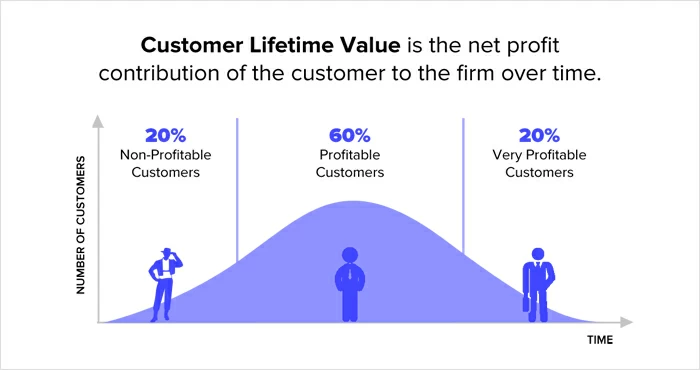

Source: https://seo.co/customer-lifetime-value/

A company should strengthen its marketing and sales activities, especially with profitable customers. With unprofitable customers, it is usually not worth the effort to keep them.


In our data set, the CLTV per customer is already included so that it does not have to be calculated first. The following CLTV distribution results:

In [ ]:
# Plot cltv distribution
cltv = df["CLTV"]

fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
for ax in axes:
    sns.kdeplot(cltv, shade=False, color='#c14953', ax=ax)
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    if ax == axes[0]:
        middle = cltv.mean()
        sdev = cltv.std()
        left = middle - sdev
        right = middle + sdev
        ax.set_title('Mean and Standard Deviation')
    else:
        left, middle, right = np.percentile(cltv, [20, 50, 80])
        ax.set_title('20% Percentile, Median, 80% Percentile')
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color="#c14953", ls=':')
    ax.fill_between(xs, 0, ys, facecolor='#c14953', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.5f}'))
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)

All customers above the 20% percentile (see figure on the right) are profitable customers.

In [ ]:
percentile20_c = np.percentile(cltv, [20])
print(percentile20_c)
type(percentile20_c)

The 20% percentile is 3175.4

Now those customers are determined who have both a high churn rate (≥60%) as well as an appropriate customer lifetime value (≥20% percentile resp. 3175.4).

In [ ]:
# Define on which customers to react - based on CLTV

cltv = df["CLTV"]
# convert array of total revenues into a dataframe
df_cltv = pd.DataFrame(cltv).reset_index(drop=True)
# convert into series
df_cltv_ = df_cltv["CLTV"]

# create list for high revenue
liste_cltv20 = []   # all customers with CLTV > 20% Percentile and
                 # Churn Rate >= 60% --> "react" list
for cltv in df_cltv_:
    if cltv >= percentile20_c:
        liste_cltv20.append(1)
    else:
        liste_cltv20.append(0)

# convert list into dataframe for high revenue
df_cltv20 = pd.DataFrame(liste_cltv20, columns=["high cltv"])

# create list for action
liste_highchurn_c = []   # all customers with CLTV > 20% Percentile and
                       # Churn Rate >= 60% --> "react" list
for p in yprednn_r:
    if p >= 0.6:
        liste_highchurn_c.append(1)
    else:
        liste_highchurn_c.append(0)
        
# convert list into dataframe for high churn
df_highchurn_c = pd.DataFrame(liste_highchurn_c, columns=["high churn"])

# concat columns
df_highhigh_c = pd.concat([df_cltv20, df_highchurn_c], axis=1, ignore_index=True)

# create column for addition
df_addition_c = pd.concat([df_cltv20, df_highchurn_c, df_highhigh_c[0]+df_highhigh_c[1]], 
                         axis=1, ignore_index=True)

# convert into series
df_addition_c_ = df_addition_c[2]

# create list for reaction
liste_react_c = []   # all customers with CLTV > 20% Percentile and
                       # Churn Rate >= 60% --> "react" list
for r in df_addition_c_:
    if r >= 2:
        liste_react_c.append("yes")
    else:
        liste_react_c.append("no")


# convert list into dataframe for reaction
df_react_c = pd.DataFrame(liste_react_c, columns=["Action yes/no"])

# concat columns
df_pred_i_react_c = pd.concat([df_pred_i, df_react_c], axis=1)

# Churn Rate Category & Action yes/no column
category_action = df_pred_i_react_c[["Churn Rate Category", "Action yes/no"]]
print(category_action)

In the following scatter plot customers with a (very) high churn rate (≥60%) as well as an appropriate customer lifetime value (≥20% percentile) are shown as dark gray points.

In [ ]:
# Plot cltv / Churn Rate / action
plt.figure(figsize=(12,7))
plot2 = sns.scatterplot(data=df_pred_i_react_c, x="CLTV", 
                y="Churn Rate", alpha=0.9,
                hue="Action yes/no",
                palette=custom_colors_yes_no_gray,
                legend=None)

For customers in dark gray in the top right corner, appropriate actions should be taken to hold them.

# 7. Outlook

Using this churn prediction model can not only help to predict, which customers are likely to churn but also to identify which of these chustomers are profitable and therefore worth taking actions to hold them.

The aim of the actions should be to establish a smooth customer journey in order to ensure positive customer experiences and thus prevent churn. The actions can be divided into short-term and long-term measures:

Short-term measures are e.g.
* Individualized customer approach, determination of the right time to approach the customer 
* Price promotions / offers
* Up-Selling / Cross-Selling

Long-term measures are e.g.
* Improvement of products / services (high product market fit)
* Optimization of the sales and resale process
* Integration of new technologies to individualize the customer journey (AI, chatbots)

Another very effective way to improve customer experience is the so-called sentiment analysis. Many customers share their feelings towards a provider in social media, by email, in chats or by telephone. Natural Language Processing (NLP) methods can be used to distinguish between friendly, factual and angry contributions. In addition, the topics of the posts can be extracted. In this way, the underlying causes of customer churn can be identified. This not only prevents individual customers from churning, but also improves the quality of the offer in the long term and precisely matches the needs of the customers.

# 8. Appendix - Look into the Black Box

In machine learning the problem between performance and interpretability occurs again and again. The better the model, the more complex and less understandable it is usually. The Random Forest algorithm, which is one of the most powerful ML algorithms today and which has also achieved very good results here, has the advantage that feature importances can be extracted. We can measure the contribution of each feature for the prediction. The function ".feature_importances_" in Scikit-Learn can be called for this purpose.

In [ ]:
# Feature Importances from Random Forest (with ScikitLearn)

# Random Forest

# Create Classifier
clf1 = RandomForestClassifier()

# Train the model 
clf1.fit(X_train, y_train)

title_cat = list(df_dummy_cat.dtypes.index)
title_num = list(num_features.dtypes.index)

title_all = title_cat + title_num

X.columns = title_all


feature_names = X.columns.tolist()

std = np.std([tree.feature_importances_ for tree in clf1.estimators_], axis=0)
sorted_index_array = np.argsort(std)
sorted_array = std[sorted_index_array]
n = 7
rslt = sorted_array[-n : ]

result = permutation_importance(clf1, X, y, n_repeats=10, 
                                random_state=42, n_jobs=2)


forest_importances = pd.Series(result.importances_mean, 
                               index=feature_names).sort_values(ascending=False)

s = forest_importances.nlargest(n=7, keep='first')

fig, ax = plt.subplots(figsize=(12,7))
s.plot.barh(yerr=rslt, ax=ax, color=custom_colors1)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Feature importances (top7)")
ax.set_ylabel("")
plt.axis([0.00, 0.80])
fig.tight_layout()


The figure above shows that customer satisfaction has by far the greatest influence on how much a customer is at risk of churn.

# 